In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

lines = open('E:\\deep learning course\\hamdan\\data.txt','r',encoding='utf=8').readlines()
lines.append('\n')

D:\anaconda3\envs\mytfenv\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
ids=[]
urls=[]
labels=[]
texts=[]
orders=[]
total_lines=[]
id=-1
url=''
order = 0
for line in lines:
    if line[0]=='#':
        id= int(line[line.index('[')+1: line.index(']')])
        url= line[line.index(']')+1:]
        order =0
    elif line != '\n':
        tokens = line.split('\t')
        labels.append(tokens[0])
        text = tokens[1].lower().translate(str.maketrans('', '', string.punctuation))
        texts.append(text)
        orders.append(order)
        order=order+1
        ids.append(id)
        urls.append(url)
    elif line =='\n' or line=='':
        for i in range(order):
          total_lines.append(order)
        order=0
        id=-1
        url=''

In [3]:
df = pd.DataFrame({'id':ids, 'text':texts, 'order': orders, 'total_lines': total_lines, 'url':urls, 'label':labels})

df.head()

,id,text,order,total_lines,url,label
0,0,هى عبارة حساسية عامة و شديدة تحدث في خلال دقائ...,0,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
1,0,و المواد التى تسبب الحساسية المفرطة عديدة و مت...,1,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
2,0,فمثلا حبوب اللقاح المتناثرة فى الجو قد تكون عا...,2,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
3,0,تختلف الأعراض لمثل هذه الحالات فى شدتها بداية ...,3,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,Symptoms
4,0,تشمل الأعراض المصاحبة لهذا المرض ما يلى \n,4,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,Symptoms


In [4]:
no_classes = len(df['label'].unique())
no_classes

5

In [5]:
unique_orders = len(df['order'].unique())
unique_orders

unique_total_lines = len(df['total_lines'].unique())
unique_total_lines

47

In [6]:
df = df.sample(frac=1.0, random_state=101)
cut_off = int(len(df)*0.7)
train_df = df[:cut_off]
test_df = df[cut_off:]

In [7]:
X_sen_train = train_df['text'].to_numpy()
X_sen_test = test_df['text'].to_numpy()

y_train = pd.get_dummies(train_df['label']).to_numpy()
y_test = pd.get_dummies(test_df['label']).to_numpy()

In [8]:
def split_chars(text):
    return ' '.join(list(text))

In [9]:
# Split sequence-level data splits into character-level data splits
X_char_train = [split_chars(sentence) for sentence in X_sen_train]
X_char_test = [split_chars(sentence) for sentence in X_sen_test]

In [10]:
train_orders_one_hot = tf.one_hot(train_df['order'].to_numpy(), depth=unique_orders)
test_orders_one_hot = tf.one_hot(test_df['order'].to_numpy(), depth=unique_orders)

In [11]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=unique_total_lines)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=unique_total_lines)

In [12]:
vocab = set()
count = 0
char_count = 0
for text in df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)

VOCAB_SIZE = len(vocab)
VOCAB_SIZE

10231

In [13]:
tokens_lens = [len(sentence.split()) for sentence in df['text'].to_numpy()]
WORD_SEQ_LENGTH = int(np.percentile(tokens_lens, 95))
WORD_SEQ_LENGTH

53

In [14]:
char_lens = [len(sentence) for sentence in df['text'].to_numpy()]
CHAR_SEQ_LENGTH = int(np.percentile(char_lens, 95))
CHAR_SEQ_LENGTH

286

In [15]:
BATCH_SIZE = 32
WORD_EMBED_SIZE = 300

In [16]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=WORD_SEQ_LENGTH)

text_vectorizer.adapt(df['text'].to_numpy())

#word_embedding = tf.keras.layers.Embedding(
#    VOCAB_SIZE,
#    WORD_EMBED_SIZE,
#    mask_zero=True
#)

In [17]:
from tqdm.auto import tqdm
from keras.initializers import Constant
from gensim.models.keyedvectors import KeyedVectors

def prepare_embedding_index(embedding_name):
    embeddings_index = {}
    if embedding_name == 'Glove':
        f = open('/content/drive/MyDrive/hamdan/embeddings/glove/vocab.txt')
        #embedding_dim = 200
    if embedding_name == 'fastText':
        f = open('E:\\deep learning course\\pretrained Arabic embeddings\\fasttext\\cc.ar.300.vec\\cc.ar.300.vec','r', encoding='utf-8')
        embedding_dim = 300
    #elif embedding_name == 'AraVec':
        #f = gensim.models.Word2Vec.load('/content/full_grams_cbow_300_twitter.mdl')
        #embedding_dim = 300
        
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    
    return embeddings_index, embedding_dim


def prepare_embedding_matrix(embeddings_index, embedding_dim, VOC_SIZE, tokenizer):
    count_known = 0
    count_unknown = 0
        
    embedding_matrix = np.zeros((VOC_SIZE, embedding_dim))

    for word, i in tqdm(tokenizer.word_index.items()):
        if i >= VOC_SIZE:
            continue
        embedding_vector = None
        try:
            embedding_vector = embeddings_index[word]
        except:
            pass
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            count_known += 1
        else:
            embedding_matrix[i] = np.random.randn(embedding_dim)
            count_unknown += 1

    print(f'{count_known} known vectors\n{count_unknown} random vectors') 
    return embedding_matrix

In [18]:
x_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE) 
x_tokenizer.fit_on_texts(df['text'].to_numpy())
embedding_matrix = prepare_embedding_matrix(*prepare_embedding_index('fastText'), VOC_SIZE=VOCAB_SIZE, tokenizer=x_tokenizer)
word_embedding = layers.Embedding(VOCAB_SIZE, embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix),input_length=WORD_SEQ_LENGTH, trainable=True)

0it [00:00, ?it/s]

  0%|          | 0/10382 [00:00<?, ?it/s]

9202 known vectors
1028 random vectors


In [19]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token

char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens= NUM_CHAR_TOKENS,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_sequence_length=CHAR_SEQ_LENGTH
)

text_chars = [" ".join(list(sentence)) for sentence in df['text'].to_numpy()]
char_vectorizer.adapt(text_chars)

In [20]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 70
5 most common characters: ['', '[UNK]', 'ا', 'ل', 'م']
5 least common characters: ['ً', 'v', '6', 'x', '8']


In [21]:
char_embedding = tf.keras.layers.Embedding(
    NUM_CHAR_TOKENS,
    25,
    mask_zero=False
)

In [22]:
# 1. Setup token inputs/model
word_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
word_vectors = text_vectorizer(word_inputs)
word_embeddings = word_embedding(word_vectors)
#xx = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(word_embeddings)
#word_output = layers.GlobalAveragePooling1D()(xx)
word_output = layers.Bidirectional(layers.LSTM(64))(word_embeddings)
word_model = tf.keras.Model(inputs=word_inputs, outputs=word_output)

In [23]:
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
yy = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(char_embeddings)
char_output = layers.Bidirectional(layers.LSTM(32))(yy)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_output)

In [24]:
# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(unique_orders,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

In [25]:
# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(unique_total_lines,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

In [26]:
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([word_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [27]:
# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_line_model.output, z])

In [28]:
# 7. Create output layer
o1 = layers.Dense(512, activation="relu")(z)
d1 = layers.Dropout(0.2)(o1)
o2 = layers.Dense(256, activation="relu")(d1)
d2 = layers.Dropout(0.2)(o2)
o3 = layers.Dense(128, activation="relu")(d2)
output_layer = layers.Dense(no_classes, activation="softmax", name="output_layer")(o3)

In [29]:
# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 word_model.input, 
                                 char_model.input],
                         outputs=output_layer)

model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 286)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 text_vectorization (TextVector  (None, 53)          0           ['token_input[0][0]']      

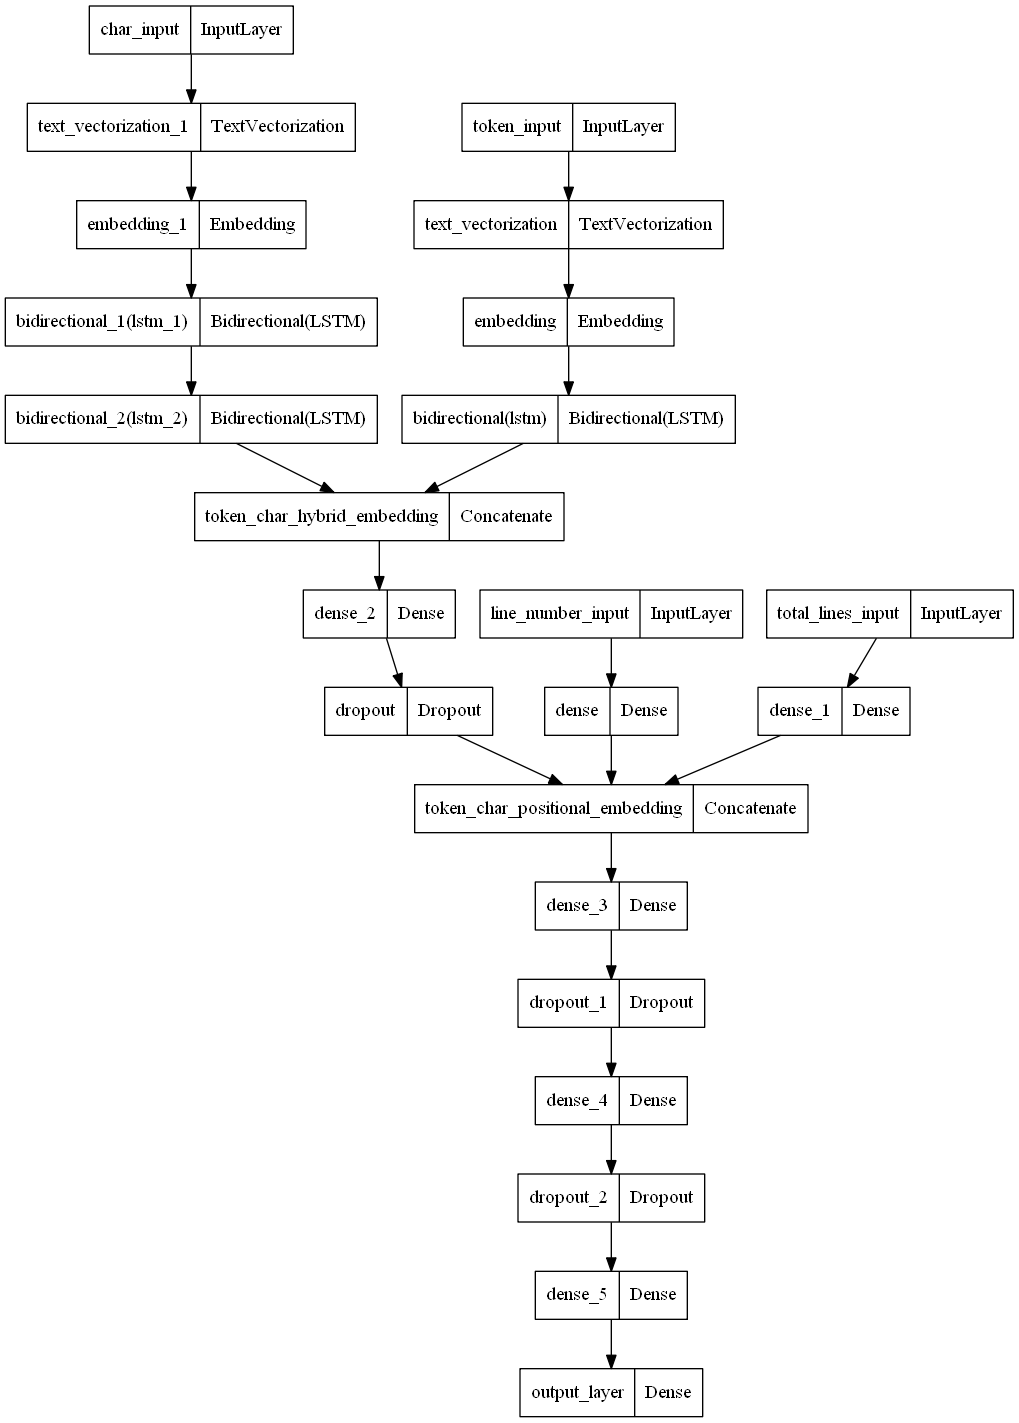

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [31]:
word_model.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'bidirectional')>

In [32]:
char_model.output

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'bidirectional_2')>

In [33]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_orders_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                X_sen_train, # train tokens
                                                                X_char_train)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(y_train) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_orders_one_hot,
                                                              test_total_lines_one_hot,
                                                              X_sen_test,
                                                              X_char_test))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

In [34]:
# Check input shapes
train_pos_char_token_dataset, test_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 98), dtype=tf.float32, name=None), TensorSpec(shape=(None, 47), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 98), dtype=tf.float32, name=None), TensorSpec(shape=(None, 47), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.uint8, name=None))>)

In [35]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=50,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

lrc = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

def create_chk(filename):
    chk = tf.keras.callbacks.ModelCheckpoint(
    filename,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None)
    return chk

In [36]:
model_5.compile(loss="categorical_crossentropy",optimizer='rmsprop', metrics=["accuracy"])

In [37]:
model_5_history = model_5.fit(train_pos_char_token_dataset, validation_data=test_pos_char_token_dataset, epochs=50)

Epoch 1/50
108/108 [==============================] - 18s 93ms/step - loss: 1.0212 - accuracy: 0.6002 - val_loss: 0.6862 - val_accuracy: 0.7551
Epoch 2/50
108/108 [==============================] - 8s 79ms/step - loss: 0.4914 - accuracy: 0.8239 - val_loss: 0.5500 - val_accuracy: 0.8173
Epoch 3/50
108/108 [==============================] - 8s 78ms/step - loss: 0.2838 - accuracy: 0.9051 - val_loss: 0.6086 - val_accuracy: 0.8288
Epoch 4/50
108/108 [==============================] - 8s 78ms/step - loss: 0.1802 - accuracy: 0.9460 - val_loss: 0.5916 - val_accuracy: 0.8714
Epoch 5/50
108/108 [==============================] - 8s 78ms/step - loss: 0.1037 - accuracy: 0.9695 - val_loss: 0.7401 - val_accuracy: 0.8701
Epoch 6/50
108/108 [==============================] - 8s 78ms/step - loss: 0.0734 - accuracy: 0.9780 - val_loss: 0.9067 - val_accuracy: 0.8633
Epoch 7/50
108/108 [==============================] - 8s 78ms/step - loss: 0.0535 - accuracy: 0.9861 - val_loss: 1.1878 - val_accuracy: 0.861

In [39]:
model_5.evaluate(test_pos_char_token_dataset)

47/47 [==============================] - 2s 34ms/step - loss: 4.8595 - accuracy: 0.8667


[4.859477996826172, 0.8667117953300476]